In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [2]:
directory = 'Dillards POS/'
skst_file_path = directory + 'skstinfo.csv'
trans_file_path = directory + 'trans_final.csv'
str_file_path = directory + 'strinfo.csv'

In [3]:
def prepare_basket(trans_file_path, skst_file_path):
    ''' function that prepares basket from the transaction table'''
    
    # Transaction table
    trans = pd.read_csv(trans_file_path)
    trans.columns = ['sku', 'storeid', 'register', 'trannum', 'interID', 'saledate', 'stype', 'quantity',
                 'orgprice', 'amt', 'seq', 'mic', 'unkown']
    # Drop all returns
    trans = trans[(trans['stype'] == 'P') & (trans['amt'] > 1) & (trans['orgprice'] > 1)]
    
    # Drop columns irrelevant to basket
    trans.drop(columns=['interID', 'stype', 'mic', 'unkown'], inplace=True)
    
    # skst table
    skst = pd.read_csv(skst_file_path, header = None)
    skst.columns = ['sku', 'storeid', 'cost', 'retail', 'unknown']
    
    # Drop columns irrelevant to basket
    skst.drop(columns = ['unknown'], inplace=True)
    
    # Get non zero mean retail for each sku
    mean_retail = skst.groupby('sku')['retail'].unique().reset_index()
    mean_retail['retail'] = mean_retail['retail'].apply(
        lambda x: sum(x) / len(x) if len(x) > 0 else 0 if len([i for i in x if i != 0]) > 0 else 0
    )
    mean_retail = mean_retail.set_index('sku')
    mean_retail_series = mean_retail['retail']
    
    # Merge transaction and skst
    trans = pd.merge(trans, skst, on=['sku','storeid'], how='left')
    
    # Fill NaN values in 'retail' with the mean retail
    trans['retail'] = trans['retail'].fillna(trans['sku'].map(mean_retail_series))
    # Fill NaN values in 'retail' with the corresponding 'orgprice' values
    trans['retail'] = trans['retail'].fillna(trans['orgprice'])
    
    # Fill NaN values in 'orgprice' with the mean retail
    trans['orgprice'] = trans['orgprice'].fillna(trans['sku'].map(mean_retail_series))
    
    
    # Feature engineering
    
    trans['saledate'] = pd.to_datetime(trans['saledate'])
    # day of week as a number (Monday=0, Sunday=6)
    trans['day_of_week'] = trans['saledate'].dt.dayofweek
    # month as a number
    trans['month'] = trans['saledate'].dt.month
    # Define weekend as Friday (4) to Sunday (6)
    trans['weekend'] = trans['day_of_week'].apply(lambda x: 1 if x >= 4 else 0)
    
    # percent discount calculated with (retail - amt) / retail
    trans['percent_discount'] = np.where(
        (trans['orgprice'] > trans['amt']) & ~np.isnan(trans['orgprice']) & ~np.isnan(trans['amt']),
        (trans['orgprice'] - trans['amt']) / trans['orgprice'],
        0
    )
    # final sale defined as > 50% descount
    trans['final_sale'] = np.where(trans['percent_discount']>0.5, 1, 0)
    return trans

In [4]:
import requests
from bs4 import BeautifulSoup
import re
# URL of the page to be scraped
url = "https://uspopulation.org/florida/33710/"

# Send a GET request to the URL
response = requests.get(url)

# If the request was successful
if response.status_code == 200:
    # Parse the HTML content of the page
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find and print the relevant data
    # (You'll need to adjust the search criteria based on the webpage's structure)
    population_data = soup.find_all('p')
    for data in population_data:
        if "population of" in data.text:
            print(data.text)
else:
    print("Failed to retrieve the webpage. Status code:", response.status_code)


33710 is a zip code in Pinellas County, Florida, which covers St. Petersburg, with a total population of 34,462 people.
The estimated population of people living in 33710 is 34,462, with a median age of 45.6.
Per capita income is the average income of a person in a given area. It is calculated by dividing the total income of 33710 by the total population of 33710.
Currently, the total population of the 33710 zip over the age of 16 is 28,921.
The total population of civilian employees that are 16 years old or older in 33710 is 17,846, with median earnings of $41,198.00.


In [5]:
strinfo = pd.read_csv(str_file_path, header = None)
strinfo.columns = ['storeid', 'city', 'state', 'zip', 'unknown']
strinfo.drop(columns=['unknown'], inplace=True)
strinfo

state_map = {
    'AL': 'alabama', 'AK': 'alaska', 'AZ': 'arizona', 'AR': 'arkansas', 'CA': 'california', 
    'CO': 'colorado', 'CT': 'connecticut', 'DE': 'delaware', 'FL': 'florida', 'GA': 'georgia', 
    'HI': 'hawaii', 'ID': 'idaho', 'IL': 'illinois', 'IN': 'indiana', 'IA': 'iowa', 
    'KS': 'kansas', 'KY': 'kentucky', 'LA': 'louisiana', 'ME': 'maine', 'MD': 'maryland', 
    'MA': 'massachusetts', 'MI': 'michigan', 'MN': 'minnesota', 'MS': 'mississippi', 'MO': 'missouri',
    'MT': 'montana', 'NE': 'nebraska', 'NV': 'nevada', 'NH': 'new-hampshire', 'NJ': 'new-jersey',
    'NM': 'new-mexico', 'NY': 'new-york', 'NC': 'north-carolina', 'ND': 'north-dakota', 'OH': 'ohio',
    'OK': 'oklahoma', 'OR': 'oregon', 'PA': 'pennsylvania', 'RI': 'rhode-island', 'SC': 'south-carolina',
    'SD': 'south-dakota', 'TN': 'tennessee', 'TX': 'texas', 'UT': 'utah', 'VT': 'vermont',
    'VA': 'virginia', 'WA': 'washington', 'WV': 'west-virginia', 'WI': 'wisconsin', 'WY': 'wyoming'
}

# Function to generate URL
def generate_url(row):
    state_abbr = row['state'].upper()
    zip_code = row['zip']
    full_state_name = state_map.get(state_abbr, state_abbr.lower())
    url = f"https://uspopulation.org/{full_state_name}/{zip_code}/"
    return url

# Function to scrape data from a URL
def scrape_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        population = median_earnings = None
        for p_tag in soup.find_all('p'):
            text = p_tag.get_text(strip=True)
            if "population of" in text and "people" in text and population is None:
                population = extract_numbers(text, 'population of')
            if "median earnings" in text and median_earnings is None:
                median_earnings = extract_numbers(text, 'median earnings of')
            if population is not None and median_earnings is not None:
                break
        return population, median_earnings
    else:
        return None, None

# Extract numbers function
def extract_numbers(text, keyword):
    match = re.search(rf"{keyword}.*?(\d[\d,]*)", text)
    return int(match.group(1).replace(',', '')) if match else None

# Add URL column to df1
strinfo['url'] = strinfo.apply(generate_url, axis=1)

# Initialize new columns
strinfo['population'] = None
strinfo['median_earning'] = None

# Iterate over the DataFrame
for index, row in strinfo.iterrows():
    population, median_earning = scrape_data(row['url'])
    strinfo.at[index, 'population'] = population
    strinfo.at[index, 'median_earning'] = median_earning

strinfo = strinfo.drop(['city', 'url'], axis=1)
# Display the DataFrame
print(strinfo)

     storeid state    zip population median_earning
0          2    FL  33710      34462          41198
1          3    MO  63126      15362          55585
2          4    AR  72201        875          63063
3          7    TX  76137      59273          42936
4          9    AZ  85281      66878          30311
..       ...   ...    ...        ...            ...
448     9808    AZ  85233      37651          53126
449     9812    LA  70006       None           None
450     9900    AR  72201        875          63063
451     9906    AR  72201        875          63063
452     9909    WY  82009       None           None

[453 rows x 5 columns]


In [6]:
def predict_and_sum(df, discount, model):
    """
    Modifies the 'mean_discount' column in the DataFrame to a specified value,
    makes predictions using the provided model, and returns the sum of predictions.

    Parameters:
    df (pd.DataFrame): The DataFrame to modify and use for predictions.
    discount (float): The discount value to set.
    model (RandomForestRegressor): The pre-trained RandomForestRegressor model.

    Returns:
    float: The sum of the predictions.
    """
    # Set the mean_discount column to the specified discount
    df['mean_discount'] = discount

    # Make predictions
    predictions = model.predict(df)

    # Sum and return the predictions
    return predictions.sum()

In [7]:
def predicted_revenue(df, discount, cost, original_price, model):
    """
    Calculates the predicted revenue.

    Parameters:
    df (pd.DataFrame): The DataFrame used for making sales predictions.
    discount (float): The discount value to apply.
    cost (float): The cost of the product.
    original_price (float): The original price of the product.
    model (RandomForestRegressor): The pre-trained RandomForestRegressor model.

    Returns:
    float: The predicted revenue.
    """
    # Get the predicted number of sales at the specified discount
    pred_sales = predict_and_sum(df, discount, model)

    # Calculate revenue: (Original Price * (1 - Discount) - Cost) * Predicted Sales
    revenue = pred_sales * (original_price * (1 - discount) - cost)
    
    return revenue

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


def get_revenues(trans_file_path, skst_file_path, sku, strinfo):
    df = prepare_basket(trans_file_path, skst_file_path)
    df = df[df['sku'] == sku]
    org = df['orgprice'].max()
    cost = df['cost'].max()
    joined_df = pd.merge(df, strinfo, on='storeid', how='inner')
    min_dates = joined_df.groupby('storeid')['saledate'].min()
    min_dates_plus_100 = min_dates + pd.Timedelta(days=100)
    min_dates_plus_100 = min_dates_plus_100.reset_index()
    min_dates_plus_100.columns = ['storeid', 'min_saledate']
    joined_df = pd.merge(joined_df, min_dates_plus_100, on='storeid', how='inner')
    joined_df['new'] = np.where(joined_df['saledate'] < joined_df['min_saledate'], 1, 0)
    sales_quantity = joined_df.groupby(['day_of_week', 'month', 'state', 'zip', 'new']).size().reset_index(name='quantity')
    mean_discount = joined_df.groupby(['day_of_week', 'month', 'state', 'zip', 'new'])['percent_discount'].mean().reset_index(name='mean_discount')
    merged = pd.merge(mean_discount, sales_quantity, on = ['day_of_week', 'month', 'state', 'zip', 'new'])
    merged = pd.merge(merged, strinfo[['zip', 'population', 'median_earning']], on='zip')
    merged = merged.drop(['zip'], axis=1)
    mean_population = merged['population'].mean()
    mean_earning = merged['median_earning'].mean()

    # Filling NaN values in specific columns with the mean of each column
    merged['population'].fillna(mean_population, inplace=True)
    merged['median_earning'].fillna(mean_earning, inplace=True)
    df_encoded = pd.get_dummies(merged, columns=['day_of_week', 'month', 'state'])
    X = df_encoded.drop('quantity', axis=1)  # Features
    y = df_encoded['quantity']  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = RandomForestRegressor(random_state=42)
    rf.fit(X_train, y_train)
    discounts = np.arange(0, 0.85, 0.05)
    print(X_test.shape)
    
    train = pd.concat([X_train, y_train], axis=1)
    train.columns = list(X_train.columns) + ['quantity']
    
    test = pd.concat([X_test, y_test], axis=1)
    test.columns = list(X_test.columns) + ['quantity']

    # Calculate predicted revenue for each discount
    # Replace the following line with your actual function calls
    predicted_revenues = [predicted_revenue(X_test, discount, cost, org, rf) for discount in discounts]
    revenue_df = pd.DataFrame({
    'Discount': discounts,
    'Predicted Revenue': predicted_revenues})

    max_revenue_row = revenue_df.loc[revenue_df['Predicted Revenue'].idxmax()]

    # Extracting the maximum predicted revenue and corresponding discount
    max_revenue = max_revenue_row['Predicted Revenue']
    max_discount = max_revenue_row['Discount']
    
    pred_sales = predict_and_sum(X_test, max_discount, rf)
    
    print(f"The current Dillards profit of sku (train): {sku} is ${sum(train['quantity']*(org*(1-train['mean_discount'])-cost))} from {sum(y_train)} sales.")
    print(f"The current Dillards profit of sku (test): {sku} is ${sum(test['quantity']*(org*(1-test['mean_discount'])-cost))} from {sum(y_test)} sales.")
    print(f"The maximum predicted profit is ${max_revenue}, occurring at a discount of {max_discount*100}% off from {pred_sales} sales.")

    # Calculate the constant value
    constant_value = sum(test['quantity'] * (org * (1 - test['mean_discount']) - cost))
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    
    # Plot the main line
    plt.plot(discounts, predicted_revenues, marker='o', label='Predicted Revenue')

    # Add the constant line
    plt.axhline(y=constant_value, color='orange', linestyle='--', label='Real Profit with original Discount Strategy')

    #plt.plot(discounts, predicted_revenues, marker='o')
    plt.title('Predicted Revenue vs. Discount')
    plt.xlabel('Discount')
    plt.ylabel('Predicted Revenue')
    plt.grid(True)
    plt.show()

(1279, 52)
The current Dillards profit of sku (train): 6470353 is $40607.09000000038 from 15629 sales.
The current Dillards profit of sku (test): 6470353 is $10559.699999999875 from 4098 sales.
The maximum predicted profit is $16677.271849283556, occurring at a discount of 5.0% off from 5750.783396304676 sales.


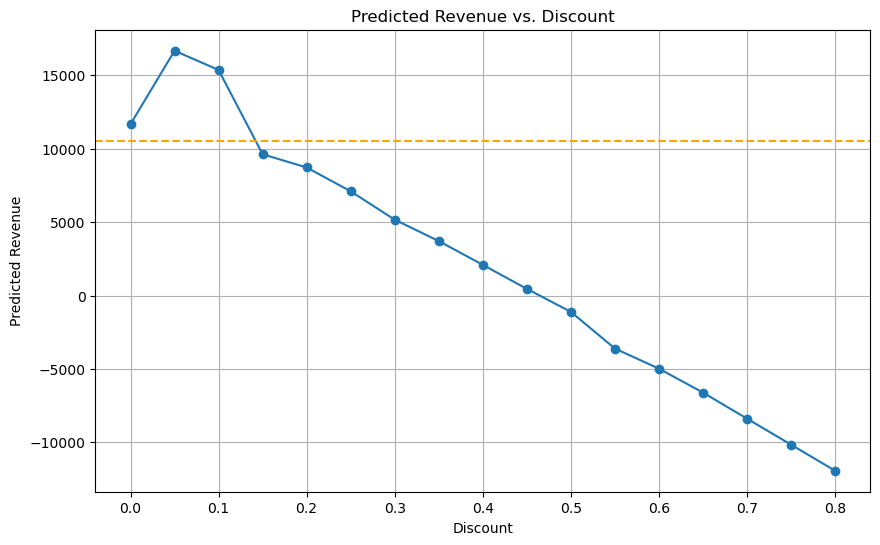

In [70]:
get_revenues(trans_file_path, skst_file_path, 6470353, strinfo)

In [ ]:
# 6696135
# 6656135

## Detailed investigation

In [13]:
df = prepare_basket(trans_file_path, skst_file_path)
df = df[df['sku'] == 6656135]
df.head()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale
57364728,6656135,102,40,9500,2004-12-23,1,8.0,5.99,306000115,3.36,2.0,3,12,0,0.25125,0
57364729,6656135,102,60,8400,2004-12-23,1,8.0,5.99,306100115,3.36,2.0,3,12,0,0.25125,0
57364730,6656135,102,180,2400,2004-12-04,1,8.0,5.99,494700099,3.36,2.0,5,12,1,0.25125,0
57364731,6656135,102,250,3900,2005-02-22,1,8.0,4.00,26300034,3.36,2.0,1,2,0,0.50000,0
57364732,6656135,102,380,8600,2004-12-23,1,8.0,5.99,316700115,3.36,2.0,3,12,0,0.25125,0


In [14]:
df.shape

(47786, 16)

In [15]:
storeid_discount_changes = df.groupby('storeid')['percent_discount'].nunique()
storeids_with_changes = storeid_discount_changes[storeid_discount_changes > 1].index
df_filtered = df[df['storeid'].isin(storeids_with_changes)]

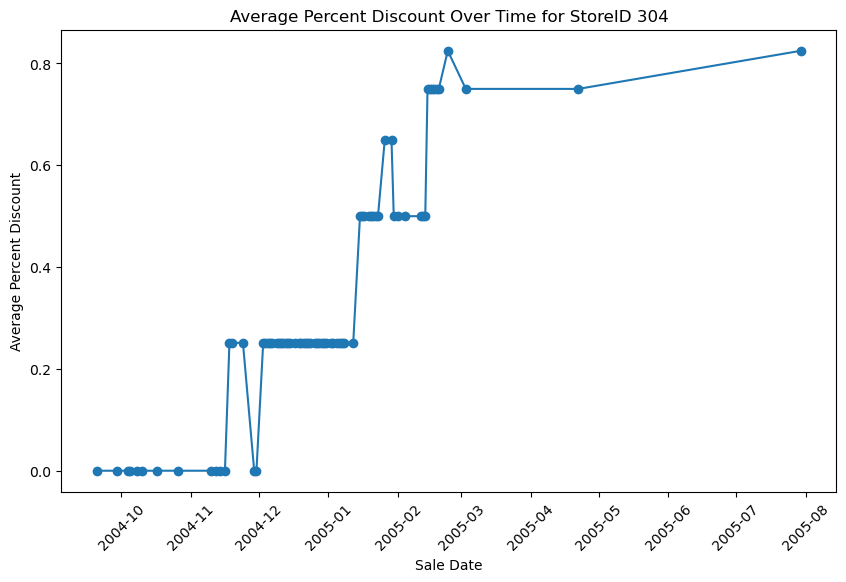

In [16]:
store_discounts = df_filtered[df_filtered['storeid'] == 304].groupby('saledate')['percent_discount'].mean()
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(store_discounts.index, store_discounts, marker='o', linestyle='-')  # Plot with markers

plt.title('Average Percent Discount Over Time for StoreID 304')
plt.xlabel('Sale Date')
plt.ylabel('Average Percent Discount')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

plt.show()


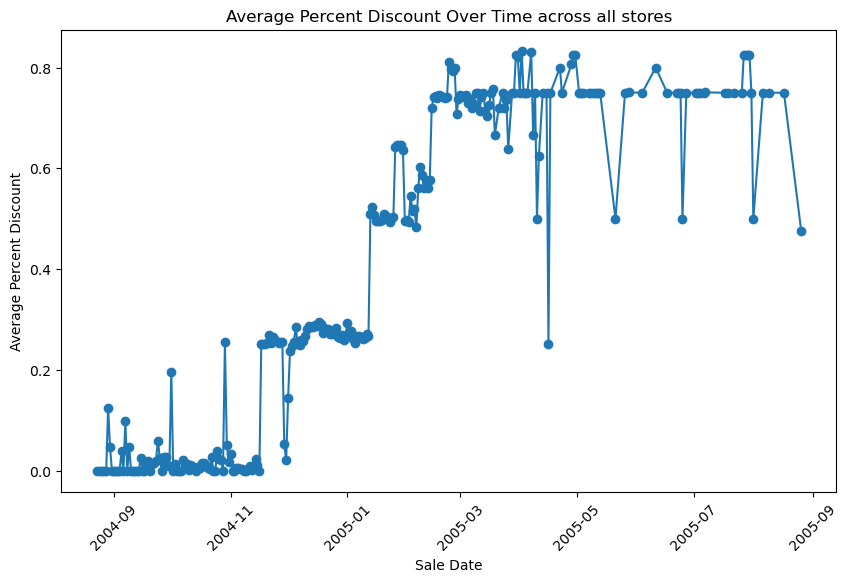

In [17]:
discounts = df.groupby('saledate')['percent_discount'].mean()
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(discounts.index, discounts, marker='o', linestyle='-')  # Plot with markers

plt.title('Average Percent Discount Over Time across all stores')
plt.xlabel('Sale Date')
plt.ylabel('Average Percent Discount')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

plt.show()



In [18]:
mean_discount_by_date = df.groupby('saledate')['percent_discount'].mean()
count_seq_by_date = df.groupby('saledate')['seq'].size()
merged_df = pd.merge(mean_discount_by_date, count_seq_by_date, left_index=True, right_index=True)
merged_df.columns = ['mean_percent_discount', 'sales']

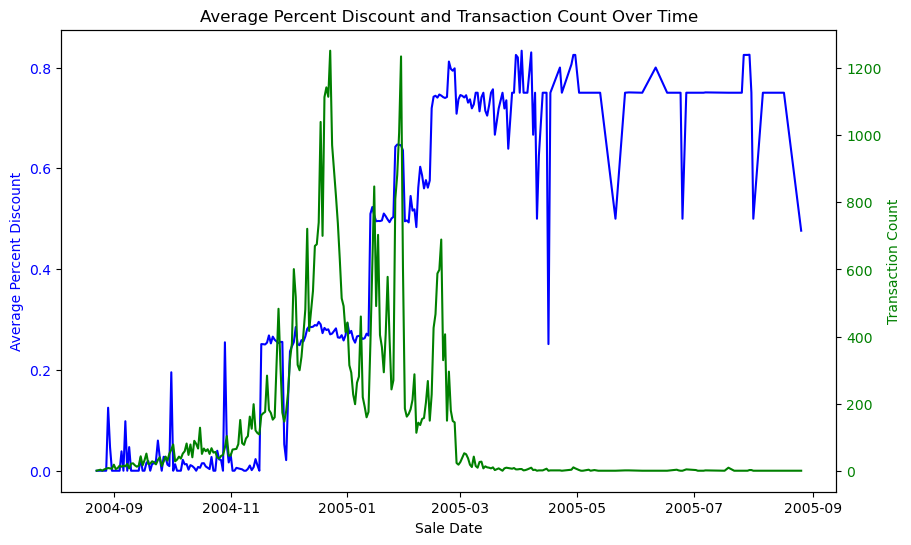

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Create the first y-axis for mean_percent_discount
ax1 = plt.gca()
ax1.plot(merged_df.index, merged_df['mean_percent_discount'], color='blue', label='Average Percent Discount')
ax1.set_xlabel('Sale Date')
ax1.set_ylabel('Average Percent Discount', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for seq_count
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(merged_df.index, merged_df['sales'], color='green', label='Transaction Count')
ax2.set_ylabel('Transaction Count', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Average Percent Discount and Transaction Count Over Time')

# Show the plot
plt.show()


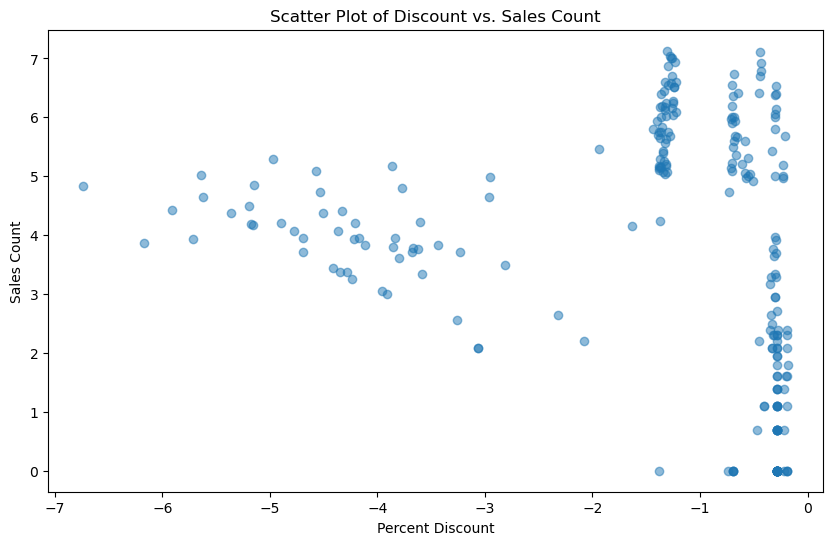

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(np.log(merged_df['mean_percent_discount']), np.log(merged_df['sales']), alpha=0.5)

plt.title('Scatter Plot of Discount vs. Sales Count')
plt.xlabel('Percent Discount')
plt.ylabel('Sales Count')

plt.show()

In [21]:
joined_df = pd.merge(df, strinfo, on='storeid', how='inner')
min_dates = joined_df.groupby('storeid')['saledate'].min()
min_dates_plus_100 = min_dates + pd.Timedelta(days=100)
min_dates_plus_100 = min_dates_plus_100.reset_index()
min_dates_plus_100.columns = ['storeid', 'min_saledate']
min_dates_plus_100

,storeid,min_saledate
0,102,2004-12-19
1,103,2004-12-30
2,107,2004-12-10
3,202,2004-12-22
4,203,2004-12-10
...,...,...
319,9704,2005-01-24
320,9709,2004-12-26
321,9804,2004-12-29
322,9806,2005-02-23


In [22]:
joined_df = pd.merge(joined_df, min_dates_plus_100, on='storeid', how='inner')
joined_df['new'] = np.where(joined_df['saledate'] < joined_df['min_saledate'], 1, 0)
joined_df

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,...,month,weekend,percent_discount,final_sale,state,zip,population,median_earning,min_saledate,new
0,6656135,102,40,9500,2004-12-23,1,8.0,5.99,306000115,3.36,...,12,0,0.25125,0,FL,33607,24171,38731,2004-12-19,0
1,6656135,102,60,8400,2004-12-23,1,8.0,5.99,306100115,3.36,...,12,0,0.25125,0,FL,33607,24171,38731,2004-12-19,0
2,6656135,102,180,2400,2004-12-04,1,8.0,5.99,494700099,3.36,...,12,1,0.25125,0,FL,33607,24171,38731,2004-12-19,1
3,6656135,102,250,3900,2005-02-22,1,8.0,4.00,26300034,3.36,...,2,0,0.50000,0,FL,33607,24171,38731,2004-12-19,0
4,6656135,102,380,8600,2004-12-23,1,8.0,5.99,316700115,3.36,...,12,0,0.25125,0,FL,33607,24171,38731,2004-12-19,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47781,6656135,9909,370,1200,2004-11-11,1,8.0,8.00,929500060,3.36,...,11,0,0.00000,0,WY,82009,None,None,2004-12-05,1
47782,6656135,9909,370,1200,2004-11-11,1,8.0,8.00,929600060,3.36,...,11,0,0.00000,0,WY,82009,None,None,2004-12-05,1
47783,6656135,9909,370,1200,2004-11-11,1,8.0,8.00,929700060,3.36,...,11,0,0.00000,0,WY,82009,None,None,2004-12-05,1
47784,6656135,9909,380,1400,2004-08-27,1,8.0,8.00,769200141,3.36,...,8,1,0.00000,0,WY,82009,None,None,2004-12-05,1


In [43]:
print(sum(joined_df['amt']))
print(sum(joined_df['cost']))
print(sum(joined_df['amt']-3.36))

237570.6199999131
nan
77009.65999998759


In [29]:
joined_df.describe()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,zip,min_saledate,new
count,47786.0,47786.000000,47786.000000,47786.000000,47786,47786.0,47786.0,47786.000000,4.778600e+04,3.032400e+04,47786.000000,47786.000000,47786.000000,47786.000000,47786.000000,47786.000000,47786.000000,47786,47786.000000
mean,6656135.0,4552.658415,462.122588,3844.569748,2004-12-30 11:52:55.105679360,1.0,8.0,4.971553,5.425041e+08,3.360000e+00,2.092567,3.174130,6.980015,0.478341,0.378909,0.239338,58566.764052,2004-12-30 02:43:59.467626496,0.455531
min,6656135.0,102.000000,1.000000,100.000000,2004-08-23 00:00:00,1.0,8.0,1.200000,2.900000e+01,3.360000e+00,0.990000,0.000000,1.000000,0.000000,0.000000,0.000000,23060.000000,2004-12-01 00:00:00,0.000000
25%,6656135.0,2109.000000,270.000000,1300.000000,2004-12-12 00:00:00,1.0,8.0,4.000000,2.900001e+08,3.360000e+00,2.000000,2.000000,1.000000,0.000000,0.251250,0.000000,37129.000000,2004-12-14 00:00:00,0.000000
50%,6656135.0,4209.000000,440.000000,2700.000000,2004-12-27 00:00:00,1.0,8.0,5.990000,5.945001e+08,3.360000e+00,2.000000,3.000000,10.000000,0.000000,0.251250,0.000000,66502.000000,2004-12-26 00:00:00,0.000000
75%,6656135.0,7107.000000,640.000000,5100.000000,2005-01-26 00:00:00,1.0,8.0,5.990000,8.279751e+08,3.360000e+00,2.245000,5.000000,12.000000,1.000000,0.500000,0.000000,77056.000000,2005-01-08 00:00:00,1.000000
max,6656135.0,9909.000000,990.000000,99900.000000,2005-08-26 00:00:00,1.0,8.0,80.000000,9.999001e+08,3.360000e+00,4.000000,6.000000,12.000000,1.000000,0.850000,1.000000,95207.000000,2005-04-15 00:00:00,1.000000
std,0.0,2864.263385,244.452304,4454.495429,NaN,0.0,0.0,1.836214,3.094580e+08,5.235898e-13,0.257501,1.934471,5.124161,0.499536,0.224487,0.426684,20716.270037,NaN,0.498024


In [26]:
sales_quantity = joined_df.groupby(['day_of_week', 'month', 'state', 'zip', 'new']).size().reset_index(name='quantity')
mean_discount = joined_df.groupby(['day_of_week', 'month', 'state', 'zip', 'new'])['percent_discount'].mean().reset_index(name='mean_discount')
merged = pd.merge(mean_discount, sales_quantity, on = ['day_of_week', 'month', 'state', 'zip', 'new'])
merged

,day_of_week,month,state,zip,new,mean_discount,quantity
0,0,1,AL,35801,0,0.500000,3
1,0,1,AL,35801,1,0.251250,2
2,0,1,AL,36117,0,0.475125,10
3,0,1,AL,36117,1,0.251250,1
4,0,1,AL,36606,0,0.500000,6
...,...,...,...,...,...,...,...
9359,6,12,VA,23452,1,0.251250,2
9360,6,12,VA,23510,0,0.251250,4
9361,6,12,VA,23602,1,0.251250,2
9362,6,12,VA,23834,1,0.375000,1


In [27]:
merged = pd.merge(merged, strinfo[['zip', 'population', 'median_earning']], on='zip')
merged = merged.drop(['zip'], axis=1)
merged.head()

,day_of_week,month,state,new,mean_discount,quantity,population,median_earning
0,0,1,AL,0,0.50000,3,None,None
1,0,1,AL,1,0.25125,2,None,None
2,0,2,AL,0,0.71875,8,None,None
3,0,11,AL,1,0.00000,3,None,None
4,0,12,AL,1,0.25125,11,None,None


In [30]:
mean_population = merged['population'].mean()
mean_earning = merged['median_earning'].mean()

# Filling NaN values in specific columns with the mean of each column
merged['population'].fillna(mean_population, inplace=True)
merged['median_earning'].fillna(mean_earning, inplace=True)
merged[merged.isna().any(axis=1)]

,day_of_week,month,state,new,mean_discount,quantity,population,median_earning


In [31]:
import pandas as pd

df_encoded = pd.get_dummies(merged, columns=['day_of_week', 'month', 'state'])

In [32]:
X = df_encoded.drop('quantity', axis=1)  # Features
y = df_encoded['quantity']               # Target variable

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
X_train.head()

,new,mean_discount,population,median_earning,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,...,state_NM,state_NV,state_OH,state_OK,state_SC,state_TN,state_TX,state_UT,state_VA,state_WY
5377,1,0.251250,34299.064535,40991.333076,False,False,False,False,False,True,...,False,False,True,False,False,False,False,False,False,False
9508,1,0.251250,75073.000000,37941.000000,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4996,0,0.375625,30223.000000,40308.000000,True,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1561,1,0.251250,24931.000000,35538.000000,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2114,0,0.750000,19308.000000,47855.000000,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [35]:
X_test.head()

,new,mean_discount,population,median_earning,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,...,state_NM,state_NV,state_OH,state_OK,state_SC,state_TN,state_TX,state_UT,state_VA,state_WY
1145,1,0.0,34299.064535,40991.333076,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8505,1,0.0,34299.064535,40991.333076,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3903,1,0.0,13239.000000,36824.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1608,1,0.0,57074.000000,39963.000000,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9141,1,0.0,22147.000000,36947.000000,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


## GBR not so good

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
y_pred = gbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

## Random Forest is better

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)


In [ ]:
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

In [ ]:
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Create a DataFrame that combines y_test and y_pred
comparison_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_series})

# Print the DataFrame
comparison_df.head(10)

In [ ]:
comparison_df.sum()

In [ ]:
comparison_df['diff'] = (comparison_df['y_test'] - comparison_df['y_pred'])
comparison_df['abs_diff'] = abs(comparison_df['diff'])
comparison_df['relative_diff'] = abs(comparison_df['y_test'] - comparison_df['y_pred'])/comparison_df['y_test']

In [ ]:
import pandas as pd

# Assuming y_test and y_pred are already defined
relative_error = abs((y_pred - y_test) / y_test) * 100
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(relative_error, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Relative Error (%)')
plt.ylabel('Frequency')
plt.title('Histogram of Relative Error in Percentages')
plt.show()


# Try different discount strategies

In [ ]:
def predict_and_sum(df, discount, model):
    """
    Modifies the 'mean_discount' column in the DataFrame to a specified value,
    makes predictions using the provided model, and returns the sum of predictions.

    Parameters:
    df (pd.DataFrame): The DataFrame to modify and use for predictions.
    discount (float): The discount value to set.
    model (RandomForestRegressor): The pre-trained RandomForestRegressor model.

    Returns:
    float: The sum of the predictions.
    """
    # Set the mean_discount column to the specified discount
    df['mean_discount'] = discount

    # Make predictions
    predictions = model.predict(df)

    # Sum and return the predictions
    return predictions.sum()

In [ ]:
def predicted_revenue(df, discount, cost, original_price, model):
    """
    Calculates the predicted revenue.

    Parameters:
    df (pd.DataFrame): The DataFrame used for making sales predictions.
    discount (float): The discount value to apply.
    cost (float): The cost of the product.
    original_price (float): The original price of the product.
    model (RandomForestRegressor): The pre-trained RandomForestRegressor model.

    Returns:
    float: The predicted revenue.
    """
    # Get the predicted number of sales at the specified discount
    pred_sales = predict_and_sum(df, discount, model)

    # Calculate revenue: (Original Price * (1 - Discount) - Cost) * Predicted Sales
    revenue = pred_sales * (original_price * (1 - discount) - cost)
    
    return revenue

In [ ]:
org = df['orgprice'].max()
cost = df['cost'].max()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

discounts = np.arange(0, 0.85, 0.05)

# Calculate predicted revenue for each discount
# Replace the following line with your actual function calls
predicted_revenues = [predicted_revenue(X_test, discount, cost, org, rf) for discount in discounts]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(discounts, predicted_revenues, marker='o')
plt.title('Predicted Revenue vs. Discount')
plt.xlabel('Discount')
plt.ylabel('Predicted Revenue')
plt.grid(True)
plt.show()


In [36]:
test = pd.concat([X_test, y_test], axis=1)
test.columns = list(X_test.columns) + ['quantity']
test.head()

,new,mean_discount,population,median_earning,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,...,state_NV,state_OH,state_OK,state_SC,state_TN,state_TX,state_UT,state_VA,state_WY,quantity
1145,1,0.0,34299.064535,40991.333076,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
8505,1,0.0,34299.064535,40991.333076,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,2
3903,1,0.0,13239.000000,36824.000000,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
1608,1,0.0,57074.000000,39963.000000,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
9141,1,0.0,22147.000000,36947.000000,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,1


In [37]:
org = df['orgprice'].max()
cost = df['cost'].max()
sum(test['quantity']*(org*(1-test['mean_discount'])-cost))

16021.079999999954

In [38]:
test['quantity']*(org*(1-test['mean_discount'])-cost)

1145     4.64
8505     9.28
3903     4.64
1608     9.28
9141     4.64
        ...  
7676    -0.08
1918     2.64
8728    12.53
4184     2.63
5955   -17.12
Length: 1945, dtype: float64

In [39]:
test['mean_discount'].describe()

count    1945.000000
mean        0.306267
std         0.233142
min         0.000000
25%         0.143571
50%         0.251250
75%         0.500000
max         0.850000
Name: mean_discount, dtype: float64

In [40]:
train = pd.concat([X_train, y_train], axis=1)
train.columns = list(X_train.columns) + ['quantity']
train.head()

,new,mean_discount,population,median_earning,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,...,state_NV,state_OH,state_OK,state_SC,state_TN,state_TX,state_UT,state_VA,state_WY,quantity
5377,1,0.251250,34299.064535,40991.333076,False,False,False,False,False,True,...,False,True,False,False,False,False,False,False,False,11
9508,1,0.251250,75073.000000,37941.000000,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,1
4996,0,0.375625,30223.000000,40308.000000,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
1561,1,0.251250,24931.000000,35538.000000,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2114,0,0.750000,19308.000000,47855.000000,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,3


In [41]:
org = df['orgprice'].max()
cost = df['cost'].max()
sum(train['quantity']*(org*(1-train['mean_discount'])-cost))

64934.05999999773